In [1]:
import tensorflow as tf

2024-10-05 00:41:15.198627: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 00:41:15.203107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 00:41:15.226724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 00:41:15.258060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 00:41:15.267805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 00:41:15.293362: I tensorflow/core/platform/cpu_feature_gu

In [3]:
print(tf.__version__)

2.17.0


In [5]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [8]:
train_csv = pd.read_csv(os.path.join(train_dir, '_annotations.csv'))
valid_csv = pd.read_csv(os.path.join(valid_dir, '_annotations.csv'))
test_csv = pd.read_csv(os.path.join(test_dir, '_annotations.csv'))

In [14]:
datagen = ImageDataGenerator(rescale=1./255)

In [17]:


train_generator = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Cambiado a 'categorical' para múltiples clases
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_csv,
    directory=valid_dir,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Cambiado a 'categorical' para múltiples clases
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 8030 validated image filenames belonging to 4 classes.
Found 780 validated image filenames belonging to 4 classes.
Found 473 validated image filenames.


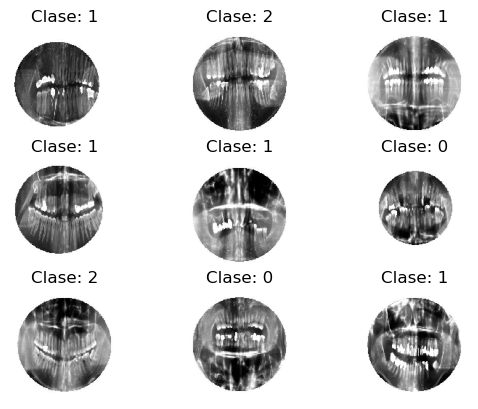

In [22]:
import matplotlib.pyplot as plt

def show_images(generator):
    x_batch, y_batch = next(generator)
    for i in range(0, 9):                
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
        plt.title(f'Clase: {y_batch[i].argmax()}')  # Mostrar la clase de la imagen
        plt.axis('off')
    plt.show()    
    

show_images(train_generator)

In [23]:
def create_simple_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
def create_rnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 150, 150, 3)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
#Entrenar los modelos:

In [ ]:
history_simple = simple_model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[tensorboard_callback])
history_cnn = cnn_model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[tensorboard_callback])
history_rnn = rnn_model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[tensorboard_callback])

In [27]:
simple_model = create_simple_model()
cnn_model = create_cnn_model()
rnn_model = create_rnn_model()

history_simple = simple_model.fit(train_generator, validation_data=valid_generator, epochs=10)
history_cnn = cnn_model.fit(train_generator, validation_data=valid_generator, epochs=10)
history_rnn = rnn_model.fit(train_generator, validation_data=valid_generator, epochs=10)

/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-10-05 01:12:19.083283: W external/loca

Epoch 1/10


/home/hduser/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 237ms/step - accuracy: 0.4835 - loss: 19.1157 - val_accuracy: 0.6923 - val_loss: 5.0440
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 192ms/step - accuracy: 0.5337 - loss: 4.8614 - val_accuracy: 0.6897 - val_loss: 1.7029
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.6006 - loss: 2.1100 - val_accuracy: 0.4718 - val_loss: 1.8220
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 182ms/step - accuracy: 0.5987 - loss: 1.7256 - val_accuracy: 0.6462 - val_loss: 1.0120
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 199ms/step - accuracy: 0.6132 - loss: 1.0792 - val_accuracy: 0.6705 - val_loss: 0.9640
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 182ms/step - accuracy: 0.6388 - loss: 0.9979 - val_accuracy: 0.6923 - val_loss: 1.0718
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 193ms/step - accuracy: 0.6381 - loss: 0.9796 - val_accuracy: 0.4821 - val_loss: 1.0869
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 182ms/step - accuracy: 0.6283 - loss: 1.0053 - va

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 150, 150, 3), dtype=float32). Expected shape (None, None, 150, 150, 3), but input has incompatible shape (None, 150, 150, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 150, 150, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Mostrar los gráficos de aprendizaje:

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

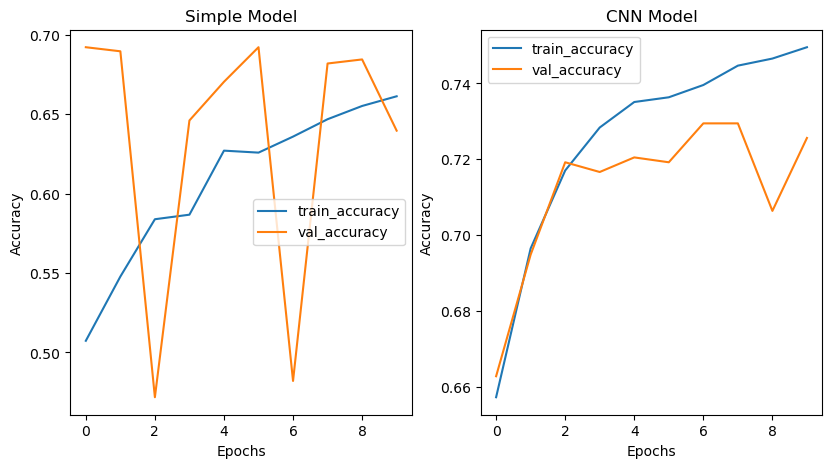

In [29]:
def plot_learning_curves(histories, titles):
    plt.figure(figsize=(15, 5))
    for i, history in enumerate(histories):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title(titles[i])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()

plot_learning_curves([history_simple, history_cnn], ['Simple Model', 'CNN Model'])